# Time Series Analysis

*Author: Ra Inta, written for BH Analytics*

*Copyright 2019—2020, BH Analytics, LLC*

A time series is a sequence of points ${X_t}$ that are related to each other as a function of time, $t$ .
In general, they may be considered a collection of random variables, otherwise known as a _stochastic process_ .
There are a number of techniques used to analyze the behavior of such time-varying phenomena.

There are frequency- and time-domain time series based analysis methods. The frequency-based, or _spectral methods_
have the advantage in that filter may be applied to reduce noise sources, and take the following model:

$$X_t = \mu + \sum _j ^{f_j} [A_j \cos{(2\pi f_j t)} + B_j \sin{(2\pi f_j t)}]$$

Where $A_j$ and $B_j$ are uncorrelated random variables and $f_{j+1} - f_j = \Delta f = \textrm{const.}$
In the time domain, we are concerned about the modeling of the relationship between a series and its past. We will be
concerned with time-domain analysis only in this section.

In particular, we will examine here the following time series analysis concepts:

  * How time series are represented in Python
  * How to achieve rolling averages and windowing
  * How to determine stationarity of a time series
  * How to examine rates of change (time derivatives) and use this to achieve stationarity
  * An overview of AR, MA and ARIMA time-series models


---

In [82]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
def print_version(library):
    print(f"{library.__name__} version: {library.__version__}")

In [85]:
print(f"Python version: {sys.version}")
print_version(np)
print_version(pd)
print_version(mpl)
print_version(sns)

Python version: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.5
pandas version: 1.0.5
matplotlib version: 3.2.2
seaborn version: 0.10.1


Set defaults for plotting figures:

In [86]:
mpl.rcParams['font.serif'] = "Georgia"
mpl.rcParams['font.family'] = "serif"

## Date and time representations in Python

How Python represents dates and times can be confusing and inconsistent. We will cover representations in three commonly encounted contexts: standard datetime objects, timedelta objects, timezone objects, and timestamp objects. 

The first three are enountered in the standard library, while the timestamp is introduced in the NumPy and pandas libraries. 

The standard library handles dates as we've seen before:

In [88]:
import datetime as dt

dt1 = dt.datetime(2020, 8, 20)

dt2 = dt.datetime.strptime("7/7/12", "%m/%d/%y")

We can easily take a difference between dates, giving us a `timedelta`:

In [89]:
dt1 - dt2

datetime.timedelta(days=2966)

There is a nice utility library for parsing dates in the standard library, `dateutil`.

You may find their documentation here: http://labix.org/python-dateutil


In [90]:
import dateutil

print(f"Easter in 2020 is {dateutil.easter.easter(2020)}")

Easter in 2020 is 2020-04-12


It handles human-readable date formats nicely:

In [94]:
dateutil.parser.parse("Oct 25th, 2019")

datetime.datetime(2019, 10, 25, 0, 0)

Time-zones are a headache for anyone. They are processed with the `tz` module in `dateutil`:

In [95]:
from numpy import sqrt

In [96]:
sqrt(5)

2.23606797749979

In [97]:
from dateutil import tz

et = dateutil.tz.gettz("US/Eastern")

utc = tz.gettz("UTC")

In [98]:
xmas_utc = dt.datetime(2020, 12, 25, tzinfo=utc)

xmas_utc

datetime.datetime(2020, 12, 25, 0, 0, tzinfo=tzwin('UTC'))

Dealing with local times is tricky and sometimes has sharp edges!

The recommendation is to work in UTC and convert to local time at the end

In [99]:
eastern_dt = dt.datetime.utcfromtimestamp(1606924000).replace(tzinfo=et)

eastern_dt

datetime.datetime(2020, 12, 2, 15, 46, 40, tzinfo=tzfile('US/Eastern'))

In [100]:
eastern_dt.strftime("The %d of %B, in the year %Y A.D.")

'The 02 of December, in the year 2020 A.D.'

What is the time difference between Xmas 2020 (UTC) and Dec. 2, 2020 (Eastern), in weeks, as a floating point number?

In [102]:
(xmas_utc - eastern_dt).days/7

3.142857142857143

Daylight savings is taken care of with `dateutil`. 

Note that daylight savings can be capricious at best; regions may decide to observe DST at short notice, or remove it completely. This is tracked by `dateutil` using an internal map based on the [IANA time zone database](https://en.wikipedia.org/wiki/Tz_database) (or 'Olson’s database'). This is updated regularly.

The print representation of `xmas_eastern` carries the daylight timezone information:

In [103]:
print(eastern_dt)

2020-12-02 15:46:40-05:00


What is the date, including possible daylight savings changes, half a year from `xmas_eastern`?

In [104]:
print(eastern_dt + dt.timedelta(days=365.25/2))

2021-06-03 06:46:40-04:00


Note the change in timezone, which is specific for US Eastern, _for that specific year_.

---

Numpy has its own date-time format:

In [105]:
np.array('2020-10-17 15:20:32.135465656', dtype=np.datetime64)

array('2020-10-17T15:20:32.135465656', dtype='datetime64[ns]')

The default range for 64-bit ns (nanoseconds) is 1678 - 2262 A.D., _i.e._ $ 1^{\text{st}} $ Jan 1970 ± 292 years.

Reference to datetimes and timedeltas: https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html

In [106]:
pd.to_datetime("October 20th, 2020")

Timestamp('2020-10-20 00:00:00')

### Datetime indices

We can use three different date-like objects as indices within pandas DataFrames

  * `Timestamp`: based on `numpy.datetime64` dttype.  Index: `DatetimeIndex`
  * `Period`: an encoding of a fixed-frequency interval. Index: `PeriodIndex`
  * `Timedelta`: a replacement for `datetime.timedelta`, based on numpy.timedelta64. Index: `TimedeltaIndex`
        
We will import some data to illustrate this. 

Let's take the S&P 500 stock index over a long period:

In [109]:
DATA_DIR = Path.cwd() / ".." / "Data"

spy_df = pd.read_csv(DATA_DIR / "economic_indicators" / "stock_indices" / "spy_500_USA.csv")

In [110]:
spy_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [111]:
spy_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-12-30,224.729996,224.830002,222.729996,223.529999,101301800,223.529999
1,2016-12-29,224.479996,224.889999,223.839996,224.350006,47719500,224.350006
2,2016-12-28,226.570007,226.589996,224.270004,224.399994,59776300,224.399994
3,2016-12-27,226.020004,226.729996,226.000000,226.270004,41054400,226.270004
4,2016-12-23,225.429993,225.720001,225.210007,225.710007,36251400,225.710007


Turn the `Date` column into a datetime object, then set that as the index:

In [ ]:
spy_df.index = spy_df["Date"]

In [112]:
spy_df["Date"] = pd.to_datetime(spy_df["Date"])

spy_df.set_index("Date", inplace=True, drop=False)

Plot the `Close` index value: 

Text(0.5, 1.0, 'S&P 500 Closing Value')

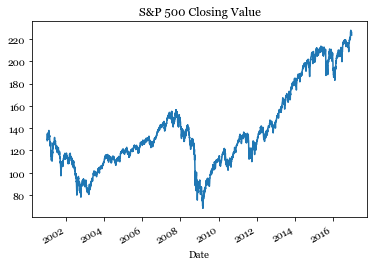

In [116]:
spy_df["Close"].plot()

plt.title("S&P 500 Closing Value")

### Resampling and rolling averages

It's 'well known' that financial data suffers from innumerable sources of noise. However, depending on the time-scale, the noise may effectively be canceled if we perform some sort of time-dependent aggregate. There are two related methods for performing this: one is to _resample_ the data, in other words, provide an alternative binning method over time. The other is a _rolling aggregate_ , whereby an aggregate is taken over a time _window_ , a specified duration that constantly moves through the time series.


The data set we have was sampled on a daily basis. Let's resample this to a monthly one to see if daily fluctuations are 'calmed':

Text(0, 0.5, 'Closing value')

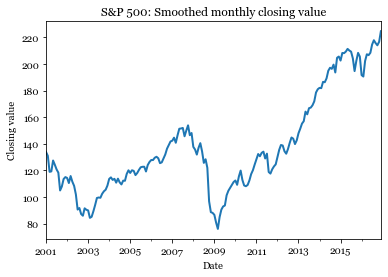

In [117]:
plt1 = spy_df["Close"].resample("M").mean()\
    .plot(title="S&P 500: Smoothed monthly closing value", 
          lw=2)

plt1.set_ylabel("Closing value")

Let us hone in on a selection of dates using `.loc[]`

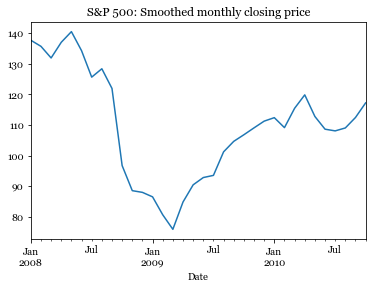

In [119]:
spy_df.resample("M")\
    .mean()\
    .loc["2008-01-02" : "2010-11-05", "Close"]\
    .plot(title="S&P 500: Smoothed monthly closing price", lw=1.5)

Oh dear. Where was the overall time series a minimum?

In [54]:
spy_df["Close"].idxmin()

Timestamp('2009-03-09 00:00:00')

The financial crash...

How many days from the crash minimum?

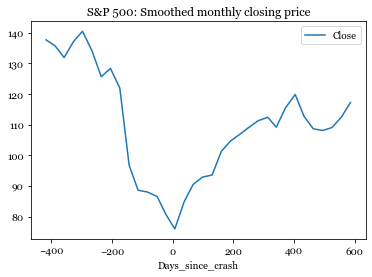

In [120]:
spy_df["Days_since_crash"] = (spy_df["Date"] - spy_df["Close"].idxmin()).dt.days

spy_df.resample("M")\
    .mean()\
    .loc["2008-01-01":"2010-11-05", ["Close", "Days_since_crash"]]\
    .plot(x="Days_since_crash", title="S&P 500: Smoothed monthly closing price", lw=1.5)

**Rolling averages**

Instead of resampling, we can take a seven-day average:

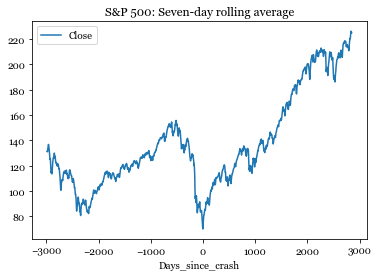

In [121]:
spy_df[["Close", "Days_since_crash"]]\
    .rolling(7, center=True)\
    .mean()\
    .plot(x="Days_since_crash", title="S&P 500: Seven-day rolling average", lw=1.5)

### Stationarity

It was mentioned above that we may consider the time series variables as a _stochastic process_ . A question is: are each of the $X_t$ independent
from each other? If so, by how much?

If there is a close dependence of the properties of points over time, then the time series is _stationary_ . In general, we should not expect this
property to occur in nature. However, there are a number of models we may consider which have desirable properties given some degree of stationarity.

**Strong stationarity**

If the joint distribution of $N$ observations, $X(t_1), X(t_2), ...$ etc. are the same as those for $X(t_1+k), X(t_2 + k),... $  for all $N, k$ then the mean,
$\mu$ and the variance, $\sigma ^2$ are constants. This is a _strongly stationary_ time series, and all higher order moments are independent of time.

If we consider the _lag_ , $k = t_2 - t_1$, then the _autocovariance_ between the two time points in time is defined as $\gamma (t_1, t_2) = \gamma (k)$, where $\gamma (0) = \sigma ^2$. We can also define the _autocorrelation_ 

$$\rho(k) = \frac{\gamma (k)}{\gamma (0)}$$ 

Plotting $\rho (k)$ vs $k$ is a _correlogram_ :

For a stationary time-series (normally distributed noise):

Text(0.5, 1.0, 'Correlogram for Gaussian noise')

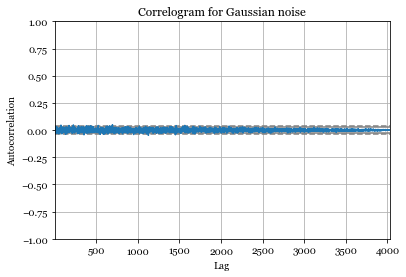

In [57]:
pd.plotting.autocorrelation_plot( np.random.randn(spy_df.shape[0]) )

plt.title("Correlogram for Gaussian noise")

Note the low magnitude of correlation: it is always within the 99% (solid) and 95% (dashed) horizontal confidence bands.

See: https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html

For our S&P500 financial data:

Text(0.5, 1.0, 'Correlogram for S&P 500 Closing')

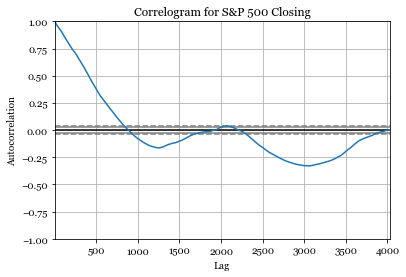

In [122]:
pd.plotting.autocorrelation_plot(spy_df["Close"])

plt.title("Correlogram for S&P 500 Closing")

It would not be appropriate to consider this a strongly stationary time series. We will use this to develop more appropriate models.


**Weak stationarity**

If we relax the assumption on higher-order moments, then the time series has _weak stationarity_ . Importantly, a normal distribution is fully determined by the
first two moments, and hence there is no difference between a strong and weak normally distributed time series.

**Non-stationarity**

Here, we expect no meaningful relationship between variables over time. For example:

$$ X_t = \mu _t + \epsilon _t$$

Where $\epsilon$ is weakly stationary.

### Time series models


 **i. Purely random**

hIf $\gamma (k) = 0$ for all $k$ and 

$$\rho =\{ ^{1\textrm{ for } k = 0} _{0\textrm{ for }k \neq 0} $$

Then we have pure _noise_ .

  **ii. Random walk**

If $\epsilon _t$ is purely random, and we have a recurrence relation 
$$X_t = X_{t-1} + \epsilon _t$$

In Python, we can create a simple instance of a random walk:

Text(0.5, 1.0, 'Daily Spot Price of Unobtainium')

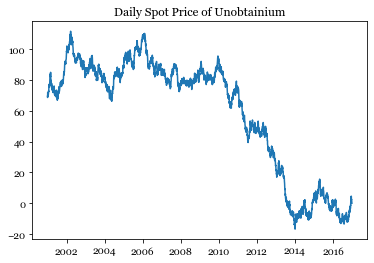

In [123]:
np.random.seed(42)

t = spy_df["Date"]

n = np.random.randn(t.shape[0])

rnd_walk = np.zeros((t.shape[0] + 1,))

for idx, __ in enumerate(t):
    rnd_walk[idx + 1]  = rnd_walk[idx] + n[idx]

rnd_walk = rnd_walk[:-1]

plt.plot(t, rnd_walk)
plt.title("Daily Spot Price of Unobtainium")

Note that, while this is non-stationary:

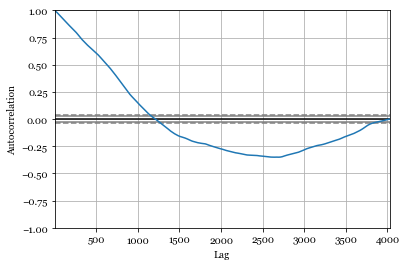

In [60]:
pd.plotting.autocorrelation_plot(rnd_walk)

Its _rate_ (time-derivative) _is_ :

Text(0.5, 1.0, 'Rate (Differenced Time Series) of Random Walk')

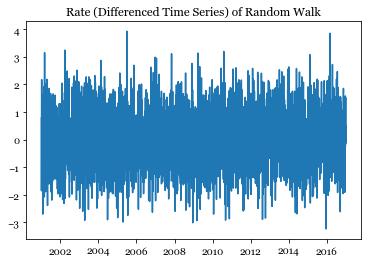

In [124]:
plt.plot(t[:-1], np.diff(rnd_walk))

plt.title("Rate (Differenced Time Series) of Random Walk")

Text(0.5, 1.0, 'Autocorrelogram of Differenced Random Walk')

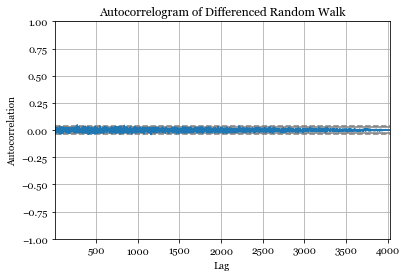

In [125]:
pd.plotting.autocorrelation_plot(np.diff(rnd_walk))

plt.title("Autocorrelogram of Differenced Random Walk")

Text(0.5, 1.0, 'Distribution of Differenced Random Walk')

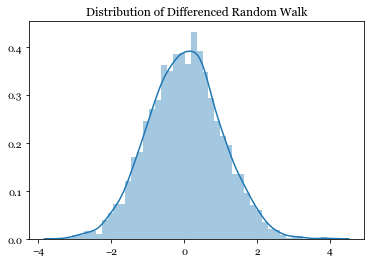

In [63]:
sns.distplot(np.diff(rnd_walk))

plt.title("Distribution of Differenced Random Walk")

What does the rate of our S&P 500 index look like?

Text(0.5, 1.0, 'Rate (Differenced Time Series) of S&P 500 Index')

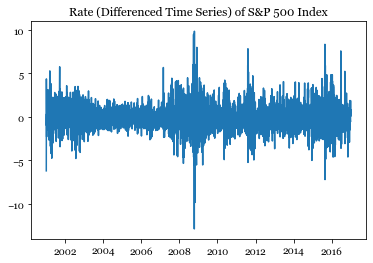

In [127]:
plt.plot(t[:-1], np.diff(spy_df["Close"]))

plt.title("Rate (Differenced Time Series) of S&P 500 Index")

Text(0.5, 1.0, 'Autocorrelogram of Differenced S&P 500 Index')

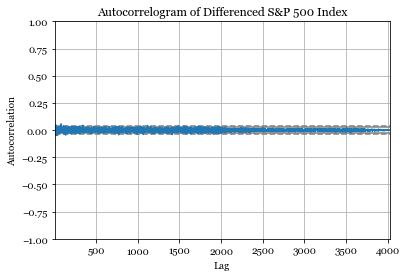

In [128]:
pd.plotting.autocorrelation_plot(np.diff(spy_df["Close"]))

plt.title("Autocorrelogram of Differenced S&P 500 Index")

Text(0.5, 1.0, 'Distribution of Differenced S&P 500 Index')

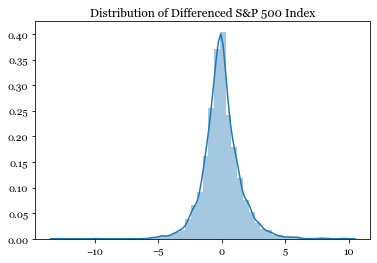

In [129]:
sns.distplot(np.diff(spy_df["Close"]))
plt.title("Distribution of Differenced S&P 500 Index")

So, a common strategy to achieve better stationarity of a time series is to take successive derivatives or differences. However: note carefully the 'fat tails' of the S&P 500 distribution. This is a common observation in financial time series that cover a significant but rare 'black swan' event.

  **iii. Moving average process (MA)**

If $\epsilon _t$ is purely random, with mean $\mu$ and variance $\sigma ^2$ , we may get a weakly stationary time series up to order
$m$ by taking:

$$ X_t = \beta _0 \epsilon _t + \beta _1 \epsilon _{t-1} + ... + \beta _m \epsilon _{t - m} $$

This is a _moving average process of order m_ , or simply MA(m).


$$\gamma (k) =\{ ^{\sigma ^2 \sum _{i=0} ^{m-k}\textrm{ for } k = 0, 1, 2, ..., m} _{0\textrm{ for }k > m} $$


  **iv. Autoregressive process (AR)**

Again, if $\epsilon _t$ is purely random, with $\bar{\epsilon _t} = 0$ and $\sigma ^2$, then:

$$X_t = \sum _{i=1}^r \alpha _i X_{t-i}i + \epsilon _t$$

Is an _autoregressive process of order r_ , or, simply, AR(r) .


  **v. Autoregressive moving average process (ARMA)**

We may combine MA and AR models from above, to get the ARMA(p, q) model:

$$X_t = \alpha _1 X_{t-1} + ... + \alpha _p X_{t-p} + \epsilon _t + \beta _1 \epsilon _{t-1} + ... + \beta _q \epsilon _{t-q}$$

  **vi. Autoregressive integrated moving average process (ARIMA)**

Most time series in reality are nonstationary. However, we may potentially approach stationarity via successive _differencing_ .
If we define a difference operator as $\Delta = 1 - L$, where $L$ is the lag operator $L^jX_t = X_{t-j}$ for all $j$.
Then $\Delta X_t = X_t - X_{t-1}$, and $\delta ^2 X_t = (X_t - X_{t-1}) - (X_{t-1} - X_{t-2})$ .
Suppose $\Delta ^d X_t$ is stationary, which can be represented by an ARMA(p, q) model. Then $X_t$ may be represented by an ARIMA(p, d, q) model. The model is _integrated_ because the stationary ARMA model has to be integrated to get back to the original time series representation.

How does this look in Python?

This is a more sophisticated model; we'll have to use the statistical package `statsmodels`:

In [130]:
from statsmodels.tsa.arima_model import ARIMA

spy_df.index = pd.DatetimeIndex(spy_df.index).to_period('D')

In [131]:
spy_df2 = spy_df[::-1].copy()

In [132]:
spy_arima320 = ARIMA(spy_df2["Close"], order=(3, 2, 0)).fit(disp=0)

Sumarize the model:

In [133]:
spy_arima320.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 4023
Model:                 ARIMA(3, 2, 0)   Log Likelihood               -7778.766
Method:                       css-mle   S.D. of innovations              1.673
Date:                Fri, 21 Aug 2020   AIC                          15567.532
Time:                        14:31:04   BIC                          15599.031
Sample:                    01-04-2001   HQIC                         15578.695
                         - 12-30-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.010     -0.044      0.965      -0.021       0.020
ar.L1.D2.Close    -0.7803      0.015    -51.079      0.000      -0.810      -0.750
ar.L2.D2.Close    -0.5383      0.018    -30.395      0.000      -0.573      -0.504
ar.L3.D2.Close    -0.2569      0.015    -16.809      0.000      -0.287      -0.227
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2119           -1.5112j            1.5260           -0.2722
AR.2           -0.2119           +1.5112j            1.5260            0.2722
AR.3           -1.6714           -0.0000j            1.6714           -0.5000
-----------------------------------------------------------------------------
"""

The terms are significant except for the overall constant.

### Goodness of fit for ARIMA models

How do we determine if our time series model is optimal --- or even appropriate?

This could be a whole lecture! One measure of goodness-of-fit is the AIC, analogously to what we've seen in linear regression.

In [134]:
print(f"{spy_arima320.aic:,.2f}")

15,567.53


Compare this to an ARIMA(1, 1, 0) model:

In [135]:
spy_arima110 = ARIMA(spy_df2["Close"], order=(1, 1, 0)).fit(disp=0)

Sumarize the model:

In [136]:
spy_arima110.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 4024
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7286.364
Method:                       css-mle   S.D. of innovations              1.480
Date:                Fri, 21 Aug 2020   AIC                          14578.728
Time:                        14:33:41   BIC                          14597.628
Sample:                    01-03-2001   HQIC                         14585.425
                         - 12-30-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0235      0.022      1.060      0.289      -0.020       0.067
ar.L1.D.Close    -0.0535      0.016     -3.394      0.001      -0.084      -0.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -18.6798           +0.0000j           18.6798            0.5000
-----------------------------------------------------------------------------
"""

In [137]:
print(f"{spy_arima110.aic:,.2f}")

14,578.73


Actually, this is 'better' (i.e. more parsimonious, and hence predictive). Let's keep this one!

Plot the residuals to see if there is any temporal structure:

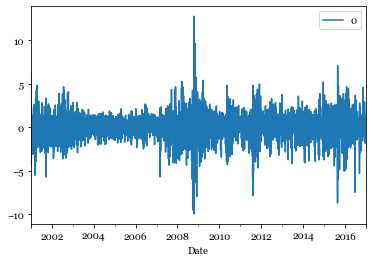

In [138]:
pd.DataFrame(spy_arima110.resid).plot()

Note the residuals are huge around the crash. There are some very large tails to the down-side:

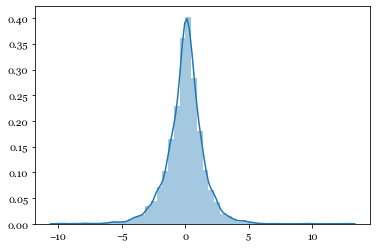

In [79]:
sns.distplot(pd.DataFrame(spy_arima110.resid))

## Trends and Seasonality

Very often a time series contains structures such as strong periodic components; these may come with yearly (_seasonal_ , $\gamma _t$) or longer (_cyclical_ , $\psi _t$) periods. Other structures may include a and/or a linear increase/decrease in magnitude over time (_trend_ ; $\mu _t$). There are various ways to model these features. 

The structural time series model decomposes a time series into components:

$y_t = \mu _t + \gamma _t + \psi _t + \epsilon _t$

Where $\epsilon _t$ is an _irregular_ , or noise, component. Parameter estimation is obtained through a maximum likelihood process (most often via a Kalman filter).

We will look at one of the simplest of these models to identify these elements separated into their components. We will illustrate this with one of the "hello world" datasets for time series: the _airline passenger_ dataset:

In [139]:
airline = pd.read_csv("../Data/airline-passengers.csv")

airline.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


This is a passenger count of airline travelers in the U.S. each month, from 1949—1960.

We will need to convert the `Month` column to a datetime object and use that as the index for our DataFrame:

In [140]:
airline.set_index(pd.to_datetime(airline["Month"]), inplace=True)

airline.drop("Month", axis="columns", inplace=True)

airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


It has a distinctive signature:

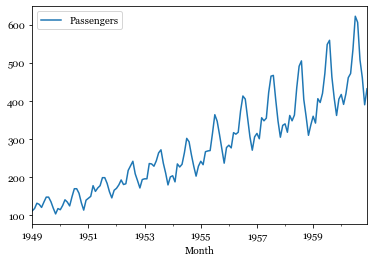

In [124]:
airline.plot()

Note the periodicity, if we take a 12-month rolling mean:

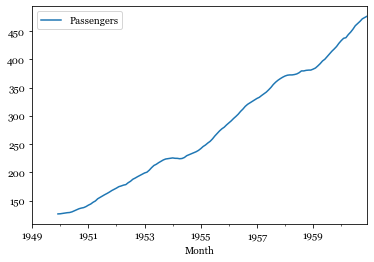

In [141]:
airline.rolling(12).mean().plot()

We will analyze the structural components using `statsmodels`' `seasonal_decompose()` function. Note we could have chosen an `additive` ($y_t = \mu _t + \gamma _t + \epsilon _t$) or a `multiplicative` model ($y_t = \mu _t \times \gamma _t \times \epsilon _t$):

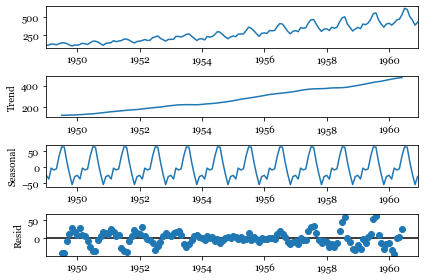

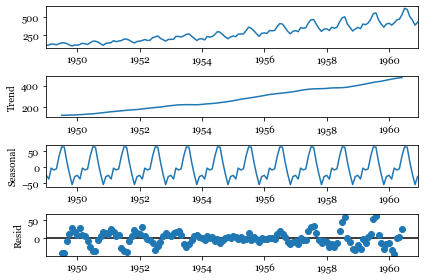

In [142]:
import statsmodels.api as sm

decomposition_add = sm.tsa.seasonal_decompose(airline, model='additive')

decomposition_add.plot()

Which is appropriate? 

If the amplitude of the cycles increases/decreases over time, then it is _multiplicative_ . If it is roughly constant, then the model is more likely _additive_ . This can be difficult to resolve, especially if a trend is also apparent. 

You can play a game to guess whether a time series has strongly additive or multiplicative cyclical components here: https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/

The multiplicative version of this model is:

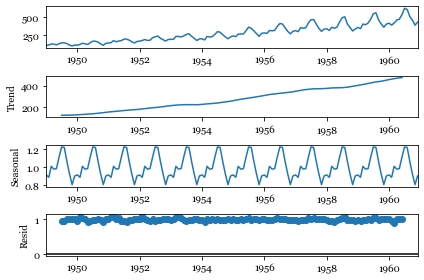

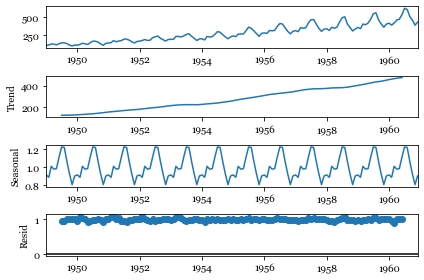

In [144]:
decomposition_mult = sm.tsa.seasonal_decompose(airline, 
                                               model='multiplicative')

decomposition_mult.plot()

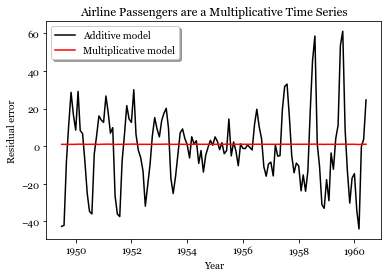

In [145]:
plt.plot(decomposition_add.resid, '-k', label="Additive model")
plt.plot(decomposition_mult.resid, '-r', label="Multiplicative model")

plt.title("Airline Passengers are a Multiplicative Time Series")
plt.ylabel("Residual error")
plt.xlabel("Year")

plt.legend(shadow=True)

Finally, we can examine how an ARIMA model for this time series might predict future passenger numbers:

In [146]:
airline_arima = ARIMA(airline, order=(2, 1, 1)).fit(disp=0)
airline_arima.summary()

C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -675.848
Method:                       css-mle   S.D. of innovations             26.881
Date:                Fri, 21 Aug 2020   AIC                           1361.696
Time:                        14:43:55   BIC                           1376.510
Sample:                    02-01-1949   HQIC                          1367.716
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6695      0.132     20.188      0.000       2.410       2.929
ar.L1.D.Passengers     1.1043      0.071     15.460      0.000       0.964       1.244
ar.L2.D.Passengers    -0.5104      0.072     -7.096      0.000      -0.651      -0.369
ma.L1.D.Passengers    -1.0000      0.029    -34.120      0.000      -1.057      -0.943
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0817           -0.8883j            1.3997           -0.1094
AR.2            1.0817           +0.8883j            1.3997            0.1094
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

This model gets less accurate over time:

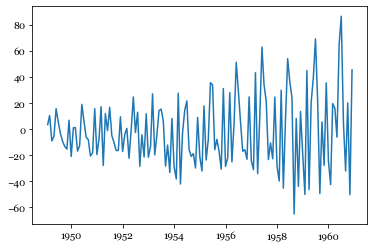

In [147]:
plt.plot(airline_arima.resid)

We can simply visualize the prediction according to this model. Note the ARIMA cannot account for the seasonality:

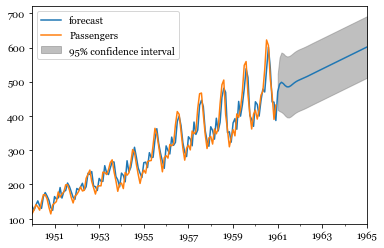

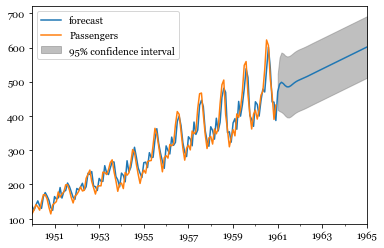

In [148]:
airline_arima.plot_predict(start="1950", end="1965")

## Conclusion

We have given a brief introduction to time-series analysis. We started by defining just _what_ a time series is,
and then looked at how to do the following in Python:

  * How to represent time series -- including time-zones -- in Python
  * How to perform resampling and rolling averages
  * How to determine stationarity of a time series, and why it's important
  * How to examine rates of change (time derivatives) and use this to achieve stationarity
  * An overview of AR, MA and ARIMA time-series models and how to execute them within Python
  * How to decompose a time series into seasonal and trend components
  * How to perform basic forecasting from a time series model

You may already be aware of how widely used time series are. Hopefully this provides you with some tools to help analyze them!